-----------------------------------------------------------------------------------------------
# Prediction of Telstra Network Disruptions
-----------------------------------------------------------------------------------------------
In their [first recruiting competition](https://www.kaggle.com/c/telstra-recruiting-network), Telstra is challenging Kagglers to predict the severity of service disruptions on their network. Using a dataset of features from their service logs, you're tasked with predicting if a disruption is a momentary glitch or a total interruption of connectivity. <img style="float: right;" src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4726/media/telstra_300.png">
Telstra is on a journey to enhance the customer experience - ensuring everyone in the company is putting customers first. In terms of its expansive network, this means continuously advancing how it predicts the scope and timing of service disruptions. Telstra wants to see how you would help it drive customer advocacy by developing a more advanced predictive model for service disruptions and to help it better serve its customers.
This challenge was crafted as a simulation of the type of problem you might tackle as a member of the team at Telstra.
## Data
The dataset is in a relational format, split among mutliple files. The following step-by-step procedure shows data sets and our method toward prediction in detail.
### Event Type Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|EventType                | type of event that occured at that ID (can be multiple events per ID)|
### Log Feature Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|Log_Feature               | type of feature logged for that ID|
|Volume              | number of times the feature was logged for that ID|
### Resource Type Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|Resource_Type              | type of resource assocaited with that ID|
### Severity Type Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|Severity_Type                | type of severity level logged for that ID|
### Training Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|Location               | identifier of location|
|Fault_Severity               | categorical. 0: no fault, 1: a few faults, 2: many faults|

## Predicting locations with higher chances of service disruption
### Step 1: Importing datasets and modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn import preprocessing
import re
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
severity_type = pd.read_csv('severity_type.csv')


The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files. 
Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

### Step 2: Data Understanding

In [3]:
print "Total number of rows", len(train)
print "Number of unique 'id'= ", train['id'].nunique()
print "Number of unique 'location' = ", train['location'].nunique()
print "Number of unique 'fault_severity' = ", train['fault_severity'].nunique()

Total number of rows 7008
Number of unique 'id'=  7008
Number of unique 'location' =  916
Number of unique 'fault_severity' =  3


In [4]:
event_type.info(), resource_type.info(), log_feature.info(), severity_type.info(), train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31170 entries, 0 to 31169
Data columns (total 2 columns):
id            31170 non-null int64
event_type    31170 non-null object
dtypes: int64(1), object(1)
memory usage: 487.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21076 entries, 0 to 21075
Data columns (total 2 columns):
id               21076 non-null int64
resource_type    21076 non-null object
dtypes: int64(1), object(1)
memory usage: 329.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58671 entries, 0 to 58670
Data columns (total 3 columns):
id             58671 non-null int64
log_feature    58671 non-null object
volume         58671 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 2 columns):
id               18552 non-null int64
severity_type    18552 non-null object
dtypes: int64(1), object(1)
memory usage: 289.9+ KB
<class 'pandas.core.frame.Da

(None, None, None, None, None)

In [5]:
train.shape

(7008, 3)

In [6]:
train.head(5)

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [7]:
train.id.nunique()

7008

In [8]:
csv_list = [event_type,log_feature,resource_type,severity_type,train]
data = reduce(lambda left,right: pd.merge(left,right,on='id'), csv_list)
data.head(2)

,id,event_type,log_feature,volume,resource_type,severity_type,location,fault_severity
0,8011,event_type 15,feature 68,7,resource_type 8,severity_type 2,location 1,0
1,2588,event_type 15,feature 82,9,resource_type 8,severity_type 1,location 1,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58812 entries, 0 to 58811
Data columns (total 8 columns):
id                58812 non-null int64
event_type        58812 non-null object
log_feature       58812 non-null object
volume            58812 non-null int64
resource_type     58812 non-null object
severity_type     58812 non-null object
location          58812 non-null object
fault_severity    58812 non-null int64
dtypes: int64(3), object(5)
memory usage: 4.0+ MB


In [10]:
# \d means 'digit'. + means, '1 or more times'. So \d+ means one or more digit. It will match 12 and 1.
data.severity_type.map(lambda x: re.findall(r'\d+',x))

0        [2]
1        [1]
2        [1]
3        [1]
4        [1]
5        [1]
6        [1]
7        [1]
8        [1]
9        [1]
10       [1]
11       [1]
12       [1]
13       [1]
14       [1]
15       [1]
16       [1]
17       [1]
18       [1]
19       [1]
20       [1]
21       [1]
22       [1]
23       [1]
24       [1]
25       [1]
26       [1]
27       [1]
28       [1]
29       [1]
        ... 
58782    [1]
58783    [2]
58784    [2]
58785    [1]
58786    [1]
58787    [1]
58788    [1]
58789    [1]
58790    [1]
58791    [1]
58792    [1]
58793    [1]
58794    [1]
58795    [1]
58796    [1]
58797    [1]
58798    [1]
58799    [1]
58800    [1]
58801    [1]
58802    [2]
58803    [1]
58804    [1]
58805    [1]
58806    [1]
58807    [2]
58808    [2]
58809    [2]
58810    [1]
58811    [1]
Name: severity_type, Length: 58812, dtype: object

In [11]:
data['severity_type'] = data.severity_type.map(lambda x: re.findall('\d+',x)[0])
data['log_feature'] = data.log_feature.map(lambda x: re.findall(r'\d+',x)[0])
data['event_type'] = data.event_type.map(lambda x: re.findall(r'\d+',x)[0])
data['resource_type'] = data.resource_type.map(lambda x: re.findall(r'\d+',x)[0])
data['location'] = data.location.map(lambda x: re.findall(r'\d+',x)[0])
data.head()

,id,event_type,log_feature,volume,resource_type,severity_type,location,fault_severity
0,8011,15,68,7,8,2,1,0
1,2588,15,82,9,8,1,1,0
2,2588,15,201,5,8,1,1,0
3,2588,15,80,15,8,1,1,0
4,2588,15,203,5,8,1,1,0


In [12]:
data.shape

(58812, 8)

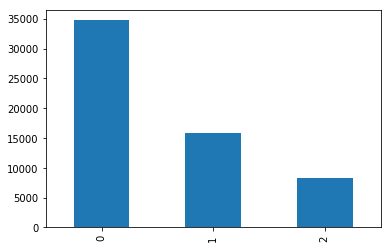

In [13]:
data['fault_severity'].value_counts().plot(kind='bar')

### Step 3: Feature Extraction

In [14]:
print data['location'].nunique()
print data['event_type'].nunique()
print data['resource_type'].nunique()
print data['severity_type'].nunique()
print data['log_feature'].nunique()
print data['fault_severity'].nunique()

916
49
10
5
329
3


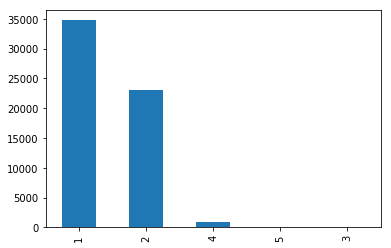

In [15]:
data['severity_type'].value_counts().plot(kind='bar')

In [16]:
data['id'].nunique(), data.shape[0]

(7008, 58812)

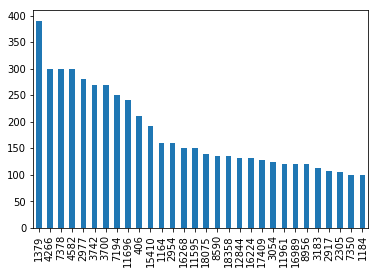

In [17]:
data.id.value_counts().head(30).plot(kind='bar')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58812 entries, 0 to 58811
Data columns (total 8 columns):
id                58812 non-null int64
event_type        58812 non-null object
log_feature       58812 non-null object
volume            58812 non-null int64
resource_type     58812 non-null object
severity_type     58812 non-null object
location          58812 non-null object
fault_severity    58812 non-null int64
dtypes: int64(3), object(5)
memory usage: 6.5+ MB


In [19]:
data = pd.get_dummies(data, drop_first=True)

In [20]:
data.head()

,id,volume,fault_severity,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_18,...,location_987,location_989,location_99,location_990,location_991,location_994,location_995,location_996,location_998,location_999
0,8011,7,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2588,9,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2588,5,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2588,15,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2588,5,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
data.fault_severity.unique()

array([0, 2, 1])

In [22]:
data.drop('fault_severity', axis=1, inplace=True)

### Step 4: Feature Selection
We use cross-correlation analysis to see how features and targets are correlated. 

In [23]:
df = data.groupby('id').sum()

In [24]:
df.shape

(7008, 1305)

In [25]:
df.reset_index(inplace=True)
df.head()

,id,volume,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_18,event_type_19,...,location_987,location_989,location_99,location_990,location_991,location_994,location_995,location_996,location_998,location_999
0,1,20,0.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df = df.merge(train,on='id',how='inner')

In [27]:
df.drop('location', axis=1, inplace=True)
df.head()

,id,volume,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_18,event_type_19,...,location_989,location_99,location_990,location_991,location_994,location_995,location_996,location_998,location_999,fault_severity
0,1,20,0.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,5,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,6,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,8,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,13,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [28]:
features = pd.DataFrame()
features['feature'] = df.columns
features['importance'] = list(abs(df.corrwith(df.fault_severity)))
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)
features.head(10)
#features.plot(kind='barh', figsize=(20, 20))

,importance
feature,
fault_severity,1.000000
log_feature_203,0.404333
log_feature_82,0.352260
event_type_15,0.334402
resource_type_8,0.258233
event_type_35,0.245484
log_feature_312,0.245364
event_type_34,0.230029
log_feature_232,0.226719


# Train and Test split

In [29]:
y = df.fault_severity
x = df.drop('fault_severity', axis=1)

In [30]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

/Users/Zia/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


((5606, 1306), (1402, 1306), (5606,), (1402,))

### Step 5: Modeling
This is a multi-class classification problem and we can choose between any classification algorithms. I decide to use Gradient Boosting and Random Forest.

In [31]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=.01, \
                                 max_depth=3, random_state=42)
gbcmodel = gbc.fit(X_train, y_train)

print gbc.score(X_test, y_test) 

0.723965763195


In [32]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators= 500, max_depth= None, max_features ='auto', random_state = 42)
rfmodel = rf.fit(X_train, y_train)

print rfmodel.score(X_test, y_test) 

0.716833095578


### Step 6: Prediction

In [33]:
# Gradient Boosting
y_predgbc = gbcmodel.predict(X_test)
print accuracy_score(y_predgbc, y_test)

# Random Forest
y_predrf = rfmodel.predict(X_test)
print accuracy_score(y_predrf, y_test)

0.723965763195
0.716833095578


#### Prediction probability

In [34]:
y_pred_proba_gbc = gbcmodel.predict_proba(X_test)

y_pred_proba_rf = rfmodel.predict_proba(X_test)

### Creating a dataframe with predictions and probability of prediction 

In [35]:
result = pd.DataFrame({
        "id": X_test.id,
        "Predicted fault_severity": y_predgbc,
        "prediction_probability_0": y_pred_proba_gbc[:,0],
        "prediction_probability_1": y_pred_proba_gbc[:,1],
        "prediction_probability_2": y_pred_proba_gbc[:,2]
    },columns=['id','Predicted fault_severity','prediction_probability_0','prediction_probability_1','prediction_probability_2'])

result.head()

,id,Predicted fault_severity,prediction_probability_0,prediction_probability_1,prediction_probability_2
2309,6120,1,0.424851,0.516432,0.058717
6089,16118,0,0.824986,0.153196,0.021818
824,2214,1,0.239115,0.489265,0.271619
6519,17291,0,0.923364,0.058295,0.018341
5860,15512,0,0.608872,0.342786,0.048342


### Save the dataframe as csv file so the operations team can open in excel

In [ ]:
result.to_csv('Service disruption prediction.csv')